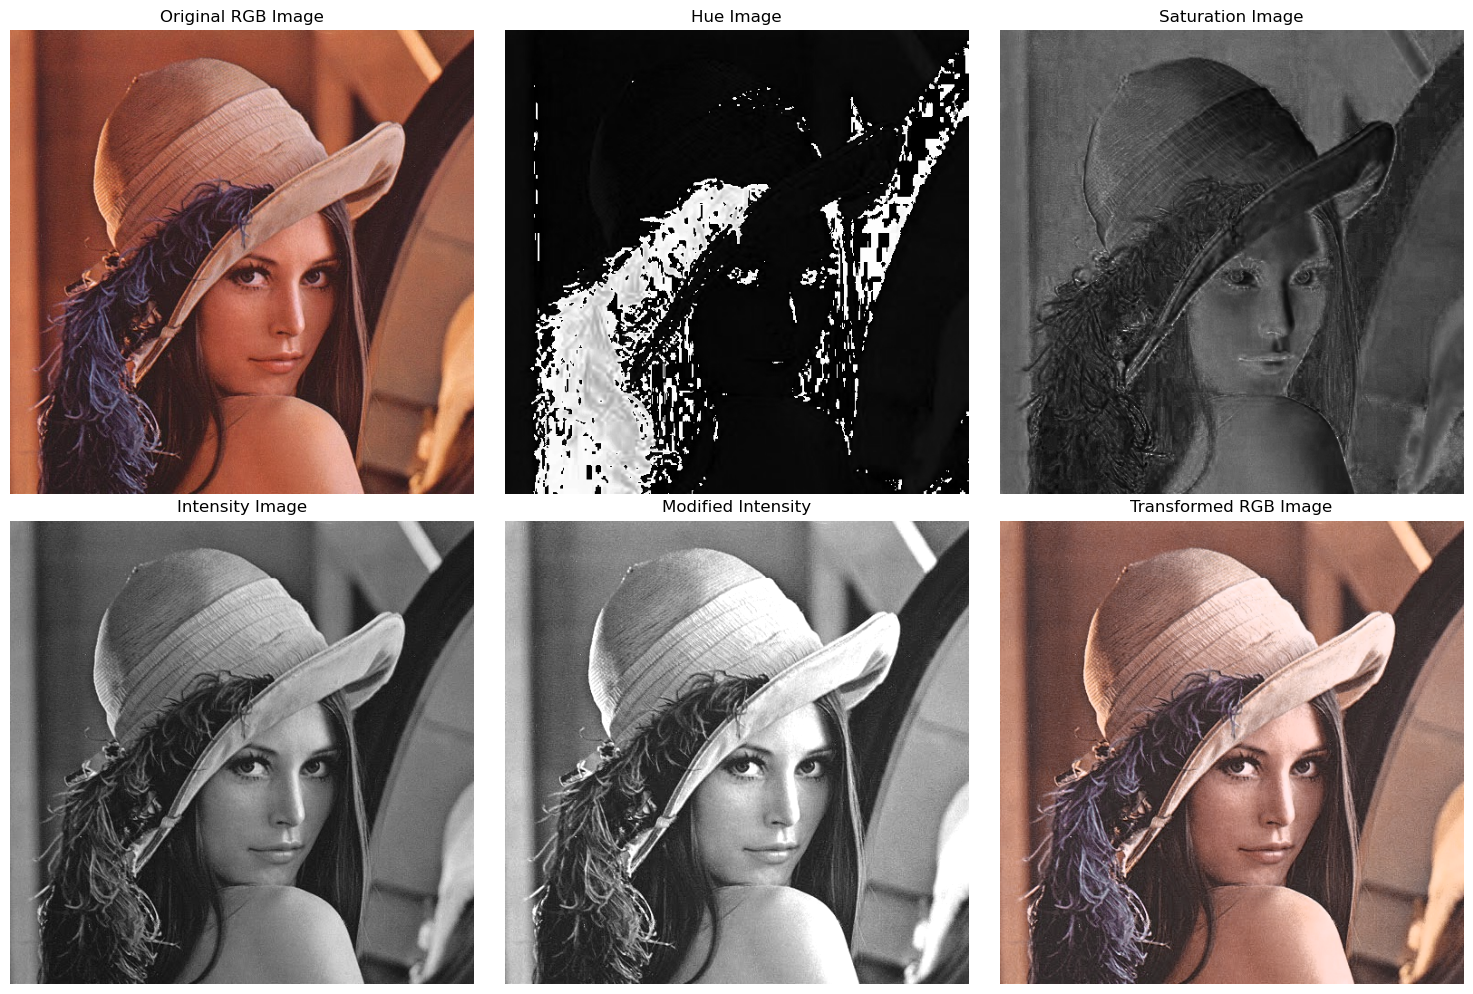

In [5]:
"""
Program Description:
This program demonstrates the conversion of an image from the RGB color model to the HSI (Hue, Saturation, Intensity) color model.
It enhances the intensity channel and visualizes the original and transformed images.

Key Concepts:
1. RGB Model:
   - Represents images using red, green, and blue channels.
   - Commonly used for digital displays but less intuitive for color analysis.

2. HSI Model:
   - Separates color information into:
     - Hue (H): Dominant wavelength of color (e.g., red, green).
     - Saturation (S): Purity or vividness of color.
     - Intensity (I): Brightness of color.

3. Conversion Steps:
   - Normalize RGB values.
   - Calculate intensity as the average of R, G, and B.
   - Compute saturation using the minimum RGB value and intensity.
   - Determine hue using trigonometric formulas and adjustments for color quadrants.
   - Normalize hue to the range [0, 1].

4. Enhancement:
   - Modify the intensity channel to enhance brightness while preserving hue and saturation.

5. Visualization:
   - Displays the following:
     - Original RGB Image
     - Hue, Saturation, and Intensity Images
     - Enhanced Intensity Image
     - Transformed RGB Image
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the HSI conversion functions
def rgb_to_hsi(rgb_image):
    """Convert RGB image to HSI color space."""
    rgb_image = rgb_image.astype(float) / 255.0  # Normalize RGB to [0, 1]
    R, G, B = rgb_image[..., 0], rgb_image[..., 1], rgb_image[..., 2]

    # Calculate Intensity
    I = (R + G + B) / 3

    # Calculate Saturation
    min_rgb = np.min(rgb_image, axis=-1)
    S = 1 - min_rgb / (I + 1e-10)  # Avoid division by zero

    # Calculate Hue
    numerator = 0.5 * ((R - G) + (R - B))
    denominator = np.sqrt((R - G) ** 2 + (R - B) * (G - B)) + 1e-10  # Avoid division by zero
    H = np.arccos(np.clip(numerator / denominator, -1, 1))  # Clip to avoid numerical issues

    # Adjust Hue based on conditions
    mask = B > G  # Mask where B > G
    H[mask] = 2 * np.pi - H[mask]  # Adjust only the masked elements
    H /= 2 * np.pi  # Normalize Hue to [0, 1]

    hsi_image = np.stack((H, S, I), axis=-1)
    return hsi_image


def hsi_to_rgb(hsi_image):
    """Convert HSI image back to RGB color space."""
    H, S, I = hsi_image[..., 0], hsi_image[..., 1], hsi_image[..., 2]
    H = H * 2 * np.pi  # Scale Hue to [0, 2*pi]

    R = np.zeros_like(H)
    G = np.zeros_like(H)
    B = np.zeros_like(H)

    sector = np.floor(H / (np.pi / 3)).astype(int) % 6
    f = (H / (np.pi / 3)) - sector
    p = I * (1 - S)
    q = I * (1 - S * f)
    t = I * (1 - S * (1 - f))

    # Assign RGB values based on the sector
    R[(sector == 0)] = I[(sector == 0)]
    G[(sector == 0)] = t[(sector == 0)]
    B[(sector == 0)] = p[(sector == 0)]

    R[(sector == 1)] = q[(sector == 1)]
    G[(sector == 1)] = I[(sector == 1)]
    B[(sector == 1)] = p[(sector == 1)]

    R[(sector == 2)] = p[(sector == 2)]
    G[(sector == 2)] = I[(sector == 2)]
    B[(sector == 2)] = t[(sector == 2)]

    R[(sector == 3)] = p[(sector == 3)]
    G[(sector == 3)] = q[(sector == 3)]
    B[(sector == 3)] = I[(sector == 3)]

    R[(sector == 4)] = t[(sector == 4)]
    G[(sector == 4)] = p[(sector == 4)]
    B[(sector == 4)] = I[(sector == 4)]

    R[(sector == 5)] = I[(sector == 5)]
    G[(sector == 5)] = p[(sector == 5)]
    B[(sector == 5)] = q[(sector == 5)]

    RGB = np.stack((R, G, B), axis=-1)
    return (RGB * 255).astype(np.uint8)

# Load the RGB image
image_path = os.path.join(os.getcwd(), 'data', 'images', 'lena_color.jpg')  # Replace with your image path
rgb_image = cv2.imread(image_path)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

# Convert RGB to HSI
hsi_image = rgb_to_hsi(rgb_image)

# Extract H, S, I components
H_image = hsi_image[..., 0]  # Hue
S_image = hsi_image[..., 1]  # Saturation
I_image = hsi_image[..., 2]  # Intensity

# Modify the Intensity component
modified_hsi = hsi_image.copy()
modified_hsi[..., 2] = np.clip(modified_hsi[..., 2] * 1.5, 0, 1)  # Amplify intensity by 50%

# Convert modified HSI back to RGB
transformed_rgb_image = hsi_to_rgb(modified_hsi)

# =========================================
# Visualization using Matplotlib
# =========================================

# Titles for display
titles = [
    "Original RGB Image", "Hue Image",
    "Saturation Image", "Intensity Image",
    "Modified Intensity", "Transformed RGB Image"
]

# Prepare images for display
images = [
    rgb_image,
    (H_image * 255).astype(np.uint8),  # Scale H to [0, 255] for display
    (S_image * 255).astype(np.uint8),  # Scale S to [0, 255] for display
    (I_image * 255).astype(np.uint8),  # Scale I to [0, 255] for display
    (modified_hsi[..., 2] * 255).astype(np.uint8),  # Scaled modified Intensity
    transformed_rgb_image
]

# Plot images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, title, img in zip(axes.flat, titles, images):
    if len(img.shape) == 2:  # Grayscale images
        ax.imshow(img, cmap='gray')
    else:  # RGB images
        ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()
